In [3]:
import io
import re
import csv
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [4]:
with open("./ReadyData_PutinG20.csv", 'r') as csvfile:
    print(f"First line (header) looks like this:\n\n{csvfile.readline()}")
    print(f"Each data point looks like this:\n\n{csvfile.readline()}")

First line (header) looks like this:

﻿vaderLabel;text

Each data point looks like this:

Positive;@SNMilitary Welcome Rusia to bali on G20, 🇮🇩  waiting  🇷🇺



In [5]:
# Loading & Preprocessing Data

def remove_stopwords(sentence):
    # List of stopwords
    stopwords = ["rt", "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]
    
    # Sentence converted to lowercase-only
    sentence = sentence.lower()

    no_stopwords = sentence.split()
    no_stopwords = [w for w in no_stopwords if w not in stopwords]
    sentence = " ".join(no_stopwords)
    sentence = re.sub('(?<=\s)@[\w]+|(?<=^)@[\w]+', '', sentence)

    alnum = sentence.split()
    alnum = [a for a in alnum if a.isalnum()]
    sentence = " ".join(alnum)
    
    return sentence

def remove_emojis(sentence):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', sentence)

def parse_data_from_file(filename):
    sentences = []
    labels = []
    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=';')
        next(reader)
        for row in reader:
            labels.append(row[0])
            sentence = row[1]
            sentence = remove_stopwords(sentence)
            sentence = remove_emojis(sentence)
            sentences.append(sentence)

    return sentences, labels

In [6]:
# Test the functions
sentences, labels = parse_data_from_file("./ReadyData_PutinG20.csv")

print(f"There are {len(sentences)} sentences in the dataset.\n")
print(f"First sentence has {len(sentences[0].split())} words (after removing stopwords).\n")
print(f"There are {len(labels)} labels in the dataset.\n")
print(f"The first 5 labels are {labels[:5]}")

There are 12462 sentences in the dataset.

First sentence has 4 words (after removing stopwords).

There are 12462 labels in the dataset.

The first 5 labels are ['Positive', 'Positive', 'Neutral', 'Negative', 'Negative']


In [7]:
# to remove duplicated from list labels
result = [] 
[result.append(x) for x in labels if x not in result] 

# printing list labels after removal 
print ("The list after removing duplicates: " + str(result)) 

The list after removing duplicates: ['Positive', 'Neutral', 'Negative']


In [8]:
# Defining useful global variables
NUM_WORDS = 500
EMBEDDING_DIM = 16
avg_sentence = sum( map(len, sentences) ) / len(sentences)
MAXLEN = round(avg_sentence)
PADDING = 'post'
OOV_TOKEN = "<OOV>"
TRAINING_SPLIT = .8

In [9]:
## Training & Validation Spli ##

def train_val_split(sentences, labels, training_split):
    
    # Compute the number of sentences that will be used for training (should be an integer)
    train_size = int(len(sentences) * training_split)

    # Split the sentences and labels into train/validation splits
    train_sentences = sentences[:train_size]
    train_labels = labels[:train_size]

    validation_sentences = sentences[train_size:]
    validation_labels = labels[train_size:]
    
    return train_sentences, validation_sentences, train_labels, validation_labels

In [10]:
# Test your function
train_sentences, val_sentences, train_labels, val_labels = train_val_split(sentences, labels, TRAINING_SPLIT)

print(f"There are {len(train_sentences)} sentences for training.\n")
print(f"There are {len(train_labels)} labels for training.\n")
print(f"There are {len(val_sentences)} sentences for validation.\n")
print(f"There are {len(val_labels)} labels for validation.")

There are 9969 sentences for training.

There are 9969 labels for training.

There are 2493 sentences for validation.

There are 2493 labels for validation.


In [11]:
## Tokenization - Sequence & Padding ##

def fit_tokenizer(train_sentences, num_words, oov_token):
        
    # Instantiate the Tokenizer class, passing in the correct values for num_words and oov_token
    tokenizer = Tokenizer(num_words, oov_token=oov_token)
    
    # Fit the tokenizer to the training sentences
    tokenizer.fit_on_texts(train_sentences)    
    
    return tokenizer

In [12]:
# Test your function
tokenizer = fit_tokenizer(train_sentences, NUM_WORDS, OOV_TOKEN)
word_index = tokenizer.word_index

print(f"Vocabulary contains {len(word_index)} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")

Vocabulary contains 1015 words

<OOV> token included in vocabulary


In [13]:
word_index

{'<OOV>': 1,
 'putin': 2,
 'g20': 3,
 'not': 4,
 'vladimir': 5,
 'allowed': 6,
 'will': 7,
 'summit': 8,
 'received': 9,
 'invite': 10,
 'invited': 11,
 'approach': 12,
 'news': 13,
 'considers': 14,
 'condemned': 15,
 'hell': 16,
 'president': 17,
 'biden': 18,
 'attend': 19,
 'war': 20,
 'go': 21,
 'arrested': 22,
 'russia': 23,
 'meet': 24,
 'attends': 25,
 'immediately': 26,
 'actually': 27,
 'get': 28,
 'attempt': 29,
 'pushing': 30,
 'continued': 31,
 'towards': 32,
 'wall': 33,
 'indonesia': 34,
 'russian': 35,
 'let': 36,
 'probably': 37,
 'still': 38,
 'nice': 39,
 'giving': 40,
 'ukraine': 41,
 'sitting': 42,
 'palace': 43,
 'indonesian': 44,
 'world': 45,
 'advisers': 46,
 'conversations': 47,
 'whose': 48,
 'widodo': 49,
 'joko': 50,
 'accepted': 51,
 'wants': 52,
 'know': 53,
 'invitation': 54,
 'happen': 55,
 'confident': 56,
 'just': 57,
 'volodymyr': 58,
 'announced': 59,
 'hosts': 60,
 'zelensky': 61,
 'really': 62,
 'time': 63,
 '20': 64,
 'group': 65,
 'nothing': 66,

In [14]:
#seq_and_pad
def seq_and_pad(sentences, tokenizer, padding, maxlen):
       
    # Convert sentences to sequences
    sequences = tokenizer.texts_to_sequences(sentences)
    
    # Pad the sequences using the correct padding and maxlen
    padded_sequences = pad_sequences(sequences, padding=padding, maxlen=maxlen)
    
    return padded_sequences

In [15]:
# Test your function
train_padded_seq = seq_and_pad(train_sentences, tokenizer, PADDING, MAXLEN)
val_padded_seq = seq_and_pad(val_sentences, tokenizer, PADDING, MAXLEN)

print(f"Padded training sequences have shape: {train_padded_seq.shape}\n")
print(f"Padded validation sequences have shape: {val_padded_seq.shape}")

Padded training sequences have shape: (9969, 45)

Padded validation sequences have shape: (2493, 45)


In [16]:
print(f"Padded training sequences:\n {train_padded_seq}\n")
print(f"Padded validation sequences:\n {val_padded_seq}")

Padded training sequences:
 [[180 436  76 ...   0   0   0]
 [  1 436 438 ...   0   0   0]
 [192  23  41 ...   0   0   0]
 ...
 [234 235 236 ...   0   0   0]
 [234 235 236 ...   0   0   0]
 [ 17  87   2 ...   0   0   0]]

Padded validation sequences:
 [[ 98 137   5 ...   0   0   0]
 [ 17  50  49 ...   0   0   0]
 [ 98 137   5 ...   0   0   0]
 ...
 [ 34 324  35 ...   0   0   0]
 [  1   5   2 ...   0   0   0]
 [  1   5   2 ...   0   0   0]]


In [17]:
# tokenize_labels

def tokenize_labels(all_labels, split_labels):
    
    # Instantiate the Tokenizer (no additional arguments needed)
    label_tokenizer = Tokenizer()
    
    # Fit the tokenizer on all the labels
    label_tokenizer.fit_on_texts(all_labels)
    
    # Convert labels to sequences
    label_seq = label_tokenizer.texts_to_sequences(split_labels)
    
    # Convert sequences to a numpy array. Don't forget to substact 1 from every entry in the array!
    label_seq_np = np.array(label_seq) - 1
    
    return label_seq_np

In [18]:
# Test your function
train_label_seq = tokenize_labels(labels, train_labels)
val_label_seq = tokenize_labels(labels, val_labels)

print(f"First 5 labels of the training set should look like this:\n{train_label_seq[:5]}\n")
print(f"First 5 labels of the validation set should look like this:\n{val_label_seq[:5]}\n")
print(f"Tokenized labels of the training set have shape: {train_label_seq.shape}\n")
print(f"Tokenized labels of the validation set have shape: {val_label_seq.shape}\n")

First 5 labels of the training set should look like this:
[[2]
 [2]
 [0]
 [1]
 [1]]

First 5 labels of the validation set should look like this:
[[0]
 [0]
 [0]
 [0]
 [0]]

Tokenized labels of the training set have shape: (9969, 1)

Tokenized labels of the validation set have shape: (2493, 1)



In [19]:
print(f"The first 5 train labels are {train_labels[:5]}\n")
print(f"The first 5 validation labels are {val_labels[:5]}\n")

# count number of each label in the data
res = {}

for i in labels:
    res[i] = labels.count(i)
    
print(f"the number of each label in the data:\n {res}")

The first 5 train labels are ['Positive', 'Positive', 'Neutral', 'Negative', 'Negative']

The first 5 validation labels are ['Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral']

the number of each label in the data:
 {'Positive': 1675, 'Neutral': 5866, 'Negative': 4921}


In [20]:
print(train_sentences[10])
print(train_padded_seq[10])

considers approach g20 summit news putin will condemned
[14 12  3  8 13  2  7 15  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


In [21]:
# GRADED FUNCTION: create_model
def create_model(num_words, embedding_dim, maxlen):
    
    tf.random.set_seed(123)
    
    ### START CODE HERE
    
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(num_words, embedding_dim, input_length=maxlen),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(6, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax'),
    ])
    
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy']) 

    ### END CODE HERE

    return model

model = create_model(NUM_WORDS, EMBEDDING_DIM, MAXLEN)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 45, 16)            8000      
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 6)                 102       
                                                                 
 dense_1 (Dense)             (None, 3)                 21        
                                                                 
Total params: 8,123
Trainable params: 8,123
Non-trainable params: 0
_________________________________________________________________


In [22]:
history = model.fit(train_padded_seq, train_label_seq, epochs=20, validation_data=(val_padded_seq, val_label_seq))

Epoch 1/20
312/312 [==============================] - 3s 5ms/step - loss: 0.9367 - accuracy: 0.4774 - val_loss: 1.1846 - val_accuracy: 0.0674
Epoch 2/20
312/312 [==============================] - 1s 5ms/step - loss: 0.6881 - accuracy: 0.7202 - val_loss: 1.2810 - val_accuracy: 0.2439
Epoch 3/20
312/312 [==============================] - 2s 5ms/step - loss: 0.4003 - accuracy: 0.8781 - val_loss: 1.2318 - val_accuracy: 0.2804
Epoch 4/20
312/312 [==============================] - 2s 5ms/step - loss: 0.2605 - accuracy: 0.8832 - val_loss: 1.2496 - val_accuracy: 0.3799
Epoch 5/20
312/312 [==============================] - 2s 5ms/step - loss: 0.1973 - accuracy: 0.8955 - val_loss: 1.1461 - val_accuracy: 0.5335
Epoch 6/20
312/312 [==============================] - 2s 5ms/step - loss: 0.1586 - accuracy: 0.9638 - val_loss: 1.1743 - val_accuracy: 0.5323
Epoch 7/20
312/312 [==============================] - 1s 5ms/step - loss: 0.1316 - accuracy: 0.9654 - val_loss: 1.1807 - val_accuracy: 0.5227
Epoch 

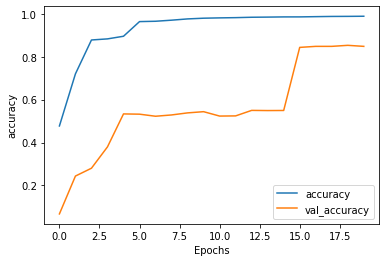

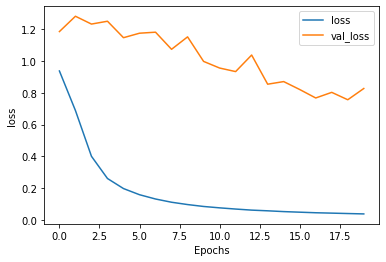

In [23]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [24]:
predictions = model.predict(train_padded_seq)

print(train_sentences[1])
print(train_labels[1])
print(train_label_seq[1])

print(predictions[1])

greatest rusia member western member wants walk free
Positive
[2]
[0.09676759 0.12076217 0.7824702 ]


In [25]:
scores = []
score = model.evaluate(val_padded_seq, val_label_seq, verbose = 1)

akurasi = score[1]
scores.append(akurasi)
y_pred = model.predict(val_padded_seq)
y_pred = y_pred.argmax(axis=1)
cm = confusion_matrix(val_label_seq, y_pred)

print(cm)
print(classification_report(val_label_seq,y_pred))

def Average(lst):
 return sum(lst) / len(lst)

print(Average(scores))


78/78 [==============================] - 0s 3ms/step - loss: 0.8266 - accuracy: 0.8484
[[1585   33   35]
 [  14   84   68]
 [  10  218  446]]
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1653
           1       0.25      0.51      0.34       166
           2       0.81      0.66      0.73       674

    accuracy                           0.85      2493
   macro avg       0.68      0.71      0.68      2493
weighted avg       0.89      0.85      0.86      2493

0.8483754396438599


## Flatten

In [26]:
# GRADED FUNCTION: create_model
def model_flatten(num_words, embedding_dim, maxlen):
    
    tf.random.set_seed(123)
    
    ### START CODE HERE
    
    modelFlatten = tf.keras.Sequential([
        tf.keras.layers.Embedding(num_words, embedding_dim, input_length=maxlen),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(6, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax'),
    ])
    
    modelFlatten.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy']) 

    ### END CODE HERE

    return modelFlatten

modelFlatten = model_flatten(NUM_WORDS, EMBEDDING_DIM, MAXLEN)
modelFlatten.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 45, 16)            8000      
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 flatten (Flatten)           (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 6)                 102       
                                                                 
 dense_3 (Dense)             (None, 3)                 21        
                                                                 
Total params: 8,123
Trainable params: 8,123
Non-trainable params: 0
____________________________________________________

In [27]:
historyFlatten = modelFlatten.fit(train_padded_seq, train_label_seq, epochs=20, validation_data=(val_padded_seq, val_label_seq))

Epoch 1/20
312/312 [==============================] - 2s 6ms/step - loss: 0.9367 - accuracy: 0.4774 - val_loss: 1.1846 - val_accuracy: 0.0674
Epoch 2/20
312/312 [==============================] - 2s 5ms/step - loss: 0.6881 - accuracy: 0.7202 - val_loss: 1.2810 - val_accuracy: 0.2439
Epoch 3/20
312/312 [==============================] - 2s 5ms/step - loss: 0.4003 - accuracy: 0.8781 - val_loss: 1.2318 - val_accuracy: 0.2804
Epoch 4/20
312/312 [==============================] - 2s 5ms/step - loss: 0.2605 - accuracy: 0.8832 - val_loss: 1.2496 - val_accuracy: 0.3799
Epoch 5/20
312/312 [==============================] - 2s 5ms/step - loss: 0.1973 - accuracy: 0.8955 - val_loss: 1.1461 - val_accuracy: 0.5335
Epoch 6/20
312/312 [==============================] - 2s 5ms/step - loss: 0.1586 - accuracy: 0.9638 - val_loss: 1.1743 - val_accuracy: 0.5323
Epoch 7/20
312/312 [==============================] - 2s 5ms/step - loss: 0.1316 - accuracy: 0.9654 - val_loss: 1.1807 - val_accuracy: 0.5227
Epoch 

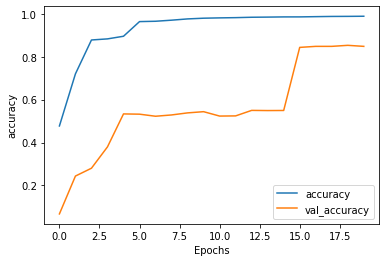

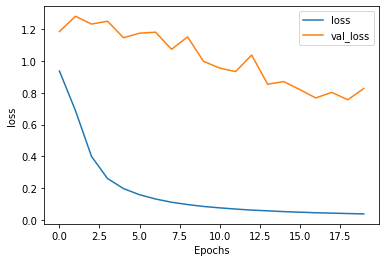

In [28]:
def plot_graphs(historyFlatten, metric):
    plt.plot(historyFlatten.history[metric])
    plt.plot(historyFlatten.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_graphs(historyFlatten, "accuracy")
plot_graphs(historyFlatten, "loss")

In [29]:
predictions = modelFlatten.predict(train_padded_seq)

print(train_sentences[1])
print(train_labels[1])
print(train_label_seq[1])

print(predictions[1])

greatest rusia member western member wants walk free
Positive
[2]
[0.09676769 0.12076212 0.7824702 ]


In [30]:
scores = []
score = modelFlatten.evaluate(val_padded_seq, val_label_seq, verbose = 1)

akurasi = score[1]
scores.append(akurasi)
y_pred = modelFlatten.predict(val_padded_seq)
y_pred = y_pred.argmax(axis=1)
cm = confusion_matrix(val_label_seq, y_pred)

print(cm)
print(classification_report(val_label_seq,y_pred))

def Average(lst):
 return sum(lst) / len(lst)

print(Average(scores))


78/78 [==============================] - 0s 3ms/step - loss: 0.8266 - accuracy: 0.8484
[[1585   33   35]
 [  14   84   68]
 [  10  218  446]]
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1653
           1       0.25      0.51      0.34       166
           2       0.81      0.66      0.73       674

    accuracy                           0.85      2493
   macro avg       0.68      0.71      0.68      2493
weighted avg       0.89      0.85      0.86      2493

0.8483754396438599


## LSTM 

In [31]:
def model_lstm(num_words, embedding_dim, maxlen):
    
    tf.random.set_seed(123)
    lstm_dim = 32
    dense_dim = 6
    ### START CODE HERE
    
    modelLSTM = tf.keras.Sequential([
        tf.keras.layers.Embedding(num_words, embedding_dim, input_length=maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)),
        tf.keras.layers.Dense(dense_dim, activation='relu'),
        tf.keras.layers.Dense(3, activation='sigmoid')
    ])
    
    modelLSTM.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy']) 

    ### END CODE HERE

    return modelLSTM

modelLSTM = model_lstm(NUM_WORDS, EMBEDDING_DIM, MAXLEN)
modelLSTM.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 45, 16)            8000      
                                                                 
 bidirectional (Bidirectiona  (None, 64)               12544     
 l)                                                              
                                                                 
 dense_4 (Dense)             (None, 6)                 390       
                                                                 
 dense_5 (Dense)             (None, 3)                 21        
                                                                 
Total params: 20,955
Trainable params: 20,955
Non-trainable params: 0
_________________________________________________________________


In [32]:
historyLSTM = modelLSTM.fit(train_padded_seq, train_label_seq, epochs=20, validation_data=(val_padded_seq, val_label_seq))

Epoch 1/20
312/312 [==============================] - 8s 16ms/step - loss: 0.3855 - accuracy: 0.8379 - val_loss: 0.8543 - val_accuracy: 0.5295
Epoch 2/20
312/312 [==============================] - 4s 13ms/step - loss: 0.0648 - accuracy: 0.9811 - val_loss: 0.9309 - val_accuracy: 0.5339
Epoch 3/20
312/312 [==============================] - 5s 15ms/step - loss: 0.0441 - accuracy: 0.9868 - val_loss: 0.5804 - val_accuracy: 0.8400
Epoch 4/20
312/312 [==============================] - 5s 15ms/step - loss: 0.0348 - accuracy: 0.9890 - val_loss: 0.8854 - val_accuracy: 0.8143
Epoch 5/20
312/312 [==============================] - 4s 13ms/step - loss: 0.0286 - accuracy: 0.9908 - val_loss: 0.5412 - val_accuracy: 0.8636
Epoch 6/20
312/312 [==============================] - 4s 14ms/step - loss: 0.0252 - accuracy: 0.9921 - val_loss: 0.5601 - val_accuracy: 0.8552
Epoch 7/20
312/312 [==============================] - 5s 15ms/step - loss: 0.0238 - accuracy: 0.9920 - val_loss: 0.5066 - val_accuracy: 0.8596

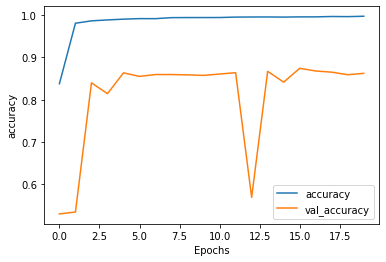

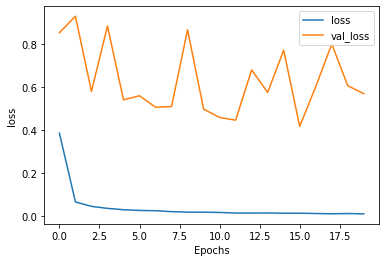

In [33]:
def plot_graphs(historyLSTM, metric):
    plt.plot(historyLSTM.history[metric])
    plt.plot(historyLSTM.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_graphs(historyLSTM, "accuracy")
plot_graphs(historyLSTM, "loss")

In [34]:
predictions = modelLSTM.predict(train_padded_seq)

print(train_sentences[1])
print(train_labels[1])
print(train_label_seq[1])

print(predictions[1])

greatest rusia member western member wants walk free
Positive
[2]
[0.01465636 0.02753395 0.91387564]


In [35]:
scores = []
score = modelLSTM.evaluate(val_padded_seq, val_label_seq, verbose = 1)

akurasi = score[1]
scores.append(akurasi)
y_pred = modelLSTM.predict(val_padded_seq)
y_pred = y_pred.argmax(axis=1)
cm = confusion_matrix(val_label_seq, y_pred)

print(cm)
print(classification_report(val_label_seq,y_pred))

def Average(lst):
 return sum(lst) / len(lst)

print(Average(scores))


78/78 [==============================] - 1s 7ms/step - loss: 0.5698 - accuracy: 0.8624
[[1615   29    9]
 [  42  101   23]
 [  64  176  434]]
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1653
           1       0.33      0.61      0.43       166
           2       0.93      0.64      0.76       674

    accuracy                           0.86      2493
   macro avg       0.73      0.74      0.72      2493
weighted avg       0.90      0.86      0.87      2493

0.8624147772789001


## GRU

In [36]:
# GRADED FUNCTION: create_model
def model_GRU(num_words, embedding_dim, maxlen):
    
    tf.random.set_seed(123)
    gru_dim = 32
    dense_dim = 6
    ### START CODE HERE
    
    modelGRU = tf.keras.Sequential([
        tf.keras.layers.Embedding(num_words, embedding_dim, input_length=maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.GRU(gru_dim)),
        tf.keras.layers.Dense(dense_dim, activation='relu'),
        tf.keras.layers.Dense(3, activation='sigmoid')
    ])
    
    modelGRU.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy']) 

    ### END CODE HERE

    return modelGRU

modelGRU = model_GRU(NUM_WORDS, EMBEDDING_DIM, MAXLEN)
modelGRU.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 45, 16)            8000      
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               9600      
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 6)                 390       
                                                                 
 dense_7 (Dense)             (None, 3)                 21        
                                                                 
Total params: 18,011
Trainable params: 18,011
Non-trainable params: 0
_________________________________________________________________


In [37]:
historyGRU = modelGRU.fit(train_padded_seq, train_label_seq, epochs=20, validation_data=(val_padded_seq, val_label_seq))

Epoch 1/20
312/312 [==============================] - 7s 14ms/step - loss: 0.3529 - accuracy: 0.8445 - val_loss: 0.6981 - val_accuracy: 0.8343
Epoch 2/20
312/312 [==============================] - 4s 13ms/step - loss: 0.0536 - accuracy: 0.9825 - val_loss: 0.8524 - val_accuracy: 0.8303
Epoch 3/20
312/312 [==============================] - 5s 15ms/step - loss: 0.0376 - accuracy: 0.9883 - val_loss: 0.7845 - val_accuracy: 0.8644
Epoch 4/20
312/312 [==============================] - 4s 14ms/step - loss: 0.0303 - accuracy: 0.9902 - val_loss: 0.7408 - val_accuracy: 0.8323
Epoch 5/20
312/312 [==============================] - 4s 14ms/step - loss: 0.0243 - accuracy: 0.9912 - val_loss: 0.7598 - val_accuracy: 0.8660
Epoch 6/20
312/312 [==============================] - 4s 14ms/step - loss: 0.0208 - accuracy: 0.9932 - val_loss: 0.7583 - val_accuracy: 0.8660
Epoch 7/20
312/312 [==============================] - 4s 13ms/step - loss: 0.0184 - accuracy: 0.9942 - val_loss: 0.8252 - val_accuracy: 0.8444

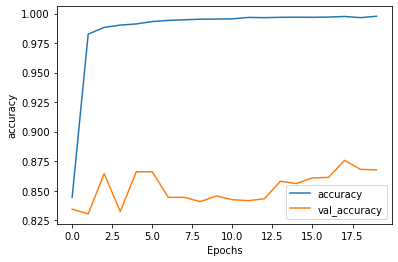

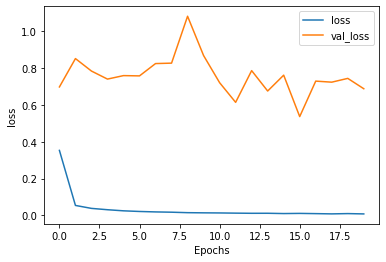

In [38]:
def plot_graphs(historyGRU, metric):
    plt.plot(historyGRU.history[metric])
    plt.plot(historyGRU.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_graphs(historyGRU, "accuracy")
plot_graphs(historyGRU, "loss")

In [39]:
predictions = modelGRU.predict(train_padded_seq)

print(train_sentences[1])
print(train_labels[1])
print(train_label_seq[1])

print(predictions[1])

greatest rusia member western member wants walk free
Positive
[2]
[0.0023203  0.00598071 0.9191968 ]


In [40]:
scores = []
score = modelGRU.evaluate(val_padded_seq, val_label_seq, verbose = 1)

akurasi = score[1]
scores.append(akurasi)
y_pred = modelGRU.predict(val_padded_seq)
y_pred = y_pred.argmax(axis=1)
cm = confusion_matrix(val_label_seq, y_pred)

print(cm)
print(classification_report(val_label_seq,y_pred))

def Average(lst):
 return sum(lst) / len(lst)

print(Average(scores))


78/78 [==============================] - 1s 7ms/step - loss: 0.6884 - accuracy: 0.8676
[[1615   25   13]
 [  44  113    9]
 [  62  177  435]]
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1653
           1       0.36      0.68      0.47       166
           2       0.95      0.65      0.77       674

    accuracy                           0.87      2493
   macro avg       0.75      0.77      0.73      2493
weighted avg       0.90      0.87      0.87      2493

0.86762934923172


## Convolution

In [41]:
# GRADED FUNCTION: create_model
def model_conv(num_words, embedding_dim, maxlen):
    
    tf.random.set_seed(123)
    filters = 64
    kernel_size = 3
    dense_dim = 6
    ### START CODE HERE
    
    modelConv = tf.keras.Sequential([
        tf.keras.layers.Embedding(num_words, embedding_dim, input_length=maxlen),
        tf.keras.layers.Conv1D(filters, kernel_size, activation='relu'),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(dense_dim, activation='relu'),
        tf.keras.layers.Dense(3, activation='sigmoid')
])
    
    modelConv.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy']) 

    ### END CODE HERE

    return modelConv

modelConv = model_conv(NUM_WORDS, EMBEDDING_DIM, MAXLEN)
modelConv.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 45, 16)            8000      
                                                                 
 conv1d (Conv1D)             (None, 43, 64)            3136      
                                                                 
 global_average_pooling1d_2   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_8 (Dense)             (None, 6)                 390       
                                                                 
 dense_9 (Dense)             (None, 3)                 21        
                                                                 
Total params: 11,547
Trainable params: 11,547
Non-trainable params: 0
__________________________________________________

In [42]:
historyConv = modelConv.fit(train_padded_seq, train_label_seq, epochs=20, validation_data=(val_padded_seq, val_label_seq))

Epoch 1/20


Error: Canceled future for execute_request message before replies were done

In [ ]:
def plot_graphs(historyConv, metric):
    plt.plot(historyConv.history[metric])
    plt.plot(historyConv.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_graphs(historyConv, "accuracy")
plot_graphs(historyConv, "loss")

In [ ]:
predictions = modelConv.predict(train_padded_seq)

print(train_sentences[1])
print(train_labels[1])
print(train_label_seq[1])

print(predictions[1])

In [ ]:
scores = []
score = modelConv.evaluate(val_padded_seq, val_label_seq, verbose = 1)

akurasi = score[1]
scores.append(akurasi)
y_pred = modelConv.predict(val_padded_seq)
y_pred = y_pred.argmax(axis=1)
cm = confusion_matrix(val_label_seq, y_pred)

print(cm)
print(classification_report(val_label_seq,y_pred))

def Average(lst):
 return sum(lst) / len(lst)

print(Average(scores))
